## Import Libraries

In [151]:
import warnings

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization libs
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Time Series cross validation
from sklearn.model_selection import TimeSeriesSplit

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

warnings.simplefilter(action="ignore", category=FutureWarning)

## Download Stock Data Function

In [133]:
import subprocess

def install(package):
    subprocess.check_call(["pip", "install", package])

# Try to import packages; if they don't exist, install them
try:
    import yfinance as yf
    import pandas as pd
except ImportError:
    install("yfinance")
    import yfinance as yf
    import pandas as pd

def download_data(symbol: str, start_date, end_date):
    try:
        print(f'>>> Downloading {symbol} stock price from yfinance Website.')
        
        # Download historical data
        data = yf.download(symbol, start=start_date, end=end_date)
        print(f'>>> Downloading {symbol} stock price is Complete.')
        print(f"{'-'}"*40)

        # Reset the index to get the 'Date' as a column
        data.reset_index(inplace=True)

        # Sort the DataFrame by the 'Date' column in ascending order
        data.sort_values(by='Date', inplace=True)

        # Convert the 'Date' column to datetime format
        data['Date'] = pd.to_datetime(data['Date'])

        # Write the merged DataFrame to a CSV file
        save_path = f"data/{symbol}_stock_price_data.csv"
        data.to_csv(save_path, index=False)
        print(f"{'-'}"*40)
        print(f'>>> Saving {symbol} stock price is complete and saved at: {save_path}')
        print(f"{'='}"*90)
        
        print(data.info())
        return data

    except Exception as e:
        print(f"Error: {e}")
        return None

In [134]:
symbol = "GOOGL"  # Replace with the desired stock symbol
start_date = "2022-01-01"
end_date = "2022-12-31"

# from download_historical_stock_data import *
stock_data = download_data(symbol, start_date, end_date)

if stock_data is not None:
    print(stock_data.info())  # Check the data types, 'Date' should be datetime64[ns]
    print(stock_data.head())


>>> Downloading GOOGL stock price from yfinance Website.
[*********************100%%**********************]  1 of 1 completed
>>> Downloading GOOGL stock price is Complete.
----------------------------------------
----------------------------------------
>>> Saving GOOGL stock price is complete and saved at: data/GOOGL_stock_price_data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       251 non-null    datetime64[ns]
 1   Open       251 non-null    float64       
 2   High       251 non-null    float64       
 3   Low        251 non-null    float64       
 4   Close      251 non-null    float64       
 5   Adj Close  251 non-null    float64       
 6   Volume     251 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 13.9 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 en

In [135]:
# ticker_symbol = "AAPL"  # Replace with the desired stock symbol
# from download_historical_stock_data import *
start_date = "2020-01-01"
end_date = "2023-12-31"
tickers = ["GOOGL", "AAPL", "MSFT", "TSLA"]

for symbol in tickers:
    data = download_data(symbol, start_date, end_date)
    print(data.info())

# download_historical_stock_data(ticker=symbol, start=start_date, end=end_date)
print()
print(f'>>> You have downloaded {len(symbol)} datasets.')

>>> Downloading GOOGL stock price from yfinance Website.
[*********************100%%**********************]  1 of 1 completed
>>> Downloading GOOGL stock price is Complete.
----------------------------------------
----------------------------------------
>>> Saving GOOGL stock price is complete and saved at: data/GOOGL_stock_price_data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1006 non-null   datetime64[ns]
 1   Open       1006 non-null   float64       
 2   High       1006 non-null   float64       
 3   Low        1006 non-null   float64       
 4   Close      1006 non-null   float64       
 5   Adj Close  1006 non-null   float64       
 6   Volume     1006 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 55.1 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006

In [136]:
from glob import glob
import os

# read file paths and printout
file_paths = glob("./data/*_stock_price_data.csv")

# For loop to read data from file paths
dataframes = []
for file in file_paths:
    data = pd.read_csv(file)
    
    # Extract the stock symbol from the file name
    symbol = os.path.basename(file).split('_')[0]
    
    # Create a new column 'symbol' based on the stock symbol
    data["symbol"] = symbol
    
    # Rearrange columns to place 'symbol' as the first column
    columns_order = ['symbol'] + [col for col in data.columns if col != 'symbol']
    data = data[columns_order]
    
    dataframes.append(data)

# Concatenate the dataframes
df = pd.concat(dataframes)

# Print the dimension of the dataframe and view the first 5 rows
print(df.shape)
print()
df.tail()


(4024, 8)



,symbol,Date,Open,High,Low,Close,Adj Close,Volume
1001,TSLA,2023-12-22,256.760010,258.220001,251.369995,252.539993,252.539993,93249800
1002,TSLA,2023-12-26,254.490005,257.970001,252.910004,256.609985,256.609985,86892400
1003,TSLA,2023-12-27,258.350006,263.339996,257.519989,261.440002,261.440002,106494400
1004,TSLA,2023-12-28,263.660004,265.130005,252.710007,253.179993,253.179993,113619900
1005,TSLA,2023-12-29,255.100006,255.190002,247.429993,248.479996,248.479996,100615300


## Wrangle Fucntion to Compute Stock Returns

In [137]:
import pandas as pd
import datetime as dt
# from sktime.utils.pandas. import flatten_multiindex

# symbol = "GOOGL"
file_path = "data/{}_stock_price_data.csv".format(symbol)

def prepare_data(file_path, symbol: str):
    
    t0 = dt.datetime.now()
    data = pd.read_csv(file_path)
    data["Rt"] = data['Adj Close'].pct_change()*100
    
    data.rename(columns={'Adj Close':'price'}, inplace=True)
    data = data[['Date', 'price','Rt']]
    data = data.dropna(axis=0)
    
    save_path = "data/{}_returns_data.csv".format(symbol)
    print(f"{'='}"*40)
    print(">>> Saving Transformed Data.")
    print(f"{'-'}"*40)
    
    pd.DataFrame(data).to_csv(save_path, index=False)
    print(">>> Saving Completed.")
    print(f"{'-'}"*40)
    
    data.set_index('Date', inplace=True)
    
    data.index = pd.to_datetime(data.index)
        
    # Now, y_sktime is a sktime compatible format, and you can use it in your sktime models
    t1 = dt.datetime.now()
    completion_time = t1 - t0

    print(f"\n>>> Transformation completed with {completion_time} completion time.")
    print(f"{'='}"*65)
    return data

## Merge Stock Data Function

This function merges all stocks price data and include a symbol column in merged dataframe.

In [138]:
from glob import glob
import os

file_paths = glob("./data/*_stock_price_data.csv")

def merge_stock_data(file_paths):
    """
    file_paths: list
            
            A list of strings containing file paths
    """
    
    # For loop to read data from file paths
    dataframes = []
    
    for file in file_paths:
        
        data = pd.read_csv(file)
    
        # Extract the stock symbol from the file name
        symbol = os.path.basename(file).split('_')[0]

        # Create a new column 'symbol' based on the stock symbol
        data["Symbol"] = symbol

        # Rearrange columns to place 'symbol' as the first column
        # columns_order = ['symbol'] + [col for col in data.columns if col != 'symbol']
        # data = data[columns_order]

        dataframes.append(data)
        
        # Concatenate the dataframes
        df = pd.concat(dataframes)
        df = df[['Date', 'Adj Close', 'Symbol']]
        df.rename(columns={'Date':'date', 'Adj Close':'price','Symbol':'symbol'}, inplace=True)
        
    return df

## Explore

In [139]:
df = prepare_data(file_path, symbol="GOOGL")
df = df[['price']]
df.head()

>>> Saving Transformed Data.
----------------------------------------
>>> Saving Completed.
----------------------------------------

>>> Transformation completed with 0:00:00.031842 completion time.


,price
Date,
2020-01-03,29.534000
2020-01-06,30.102667
2020-01-07,31.270666
2020-01-08,32.809334
2020-01-09,32.089333


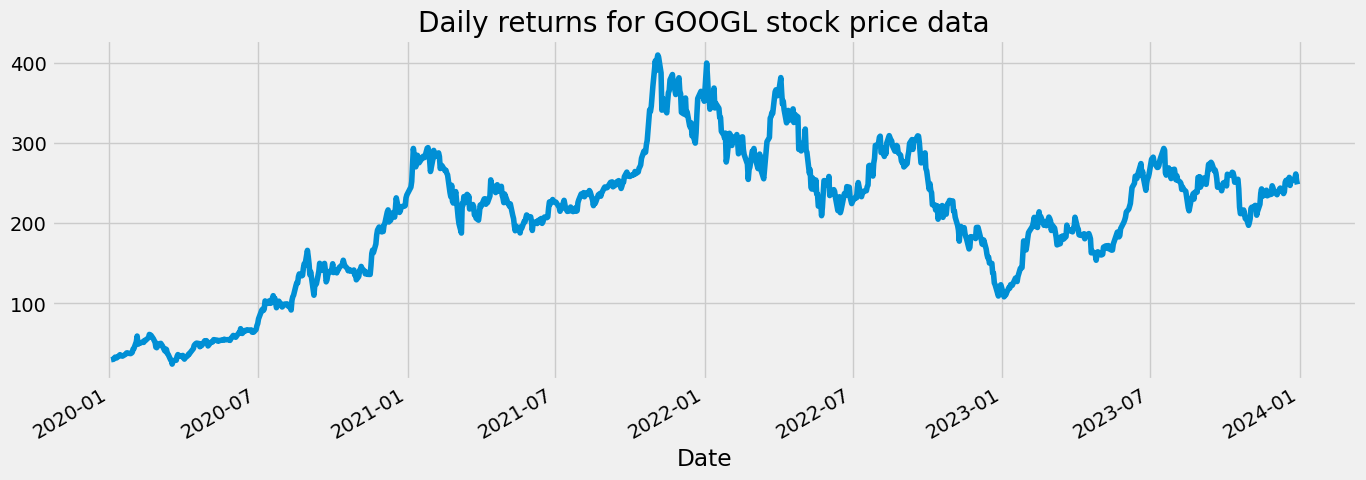

In [140]:
df.price.plot(style='-',
        figsize=(15,5),
        color=color_pal[0:2],
        title='Daily returns for GOOGL stock price data'
       )
plt.show()

<Axes: xlabel='Date'>

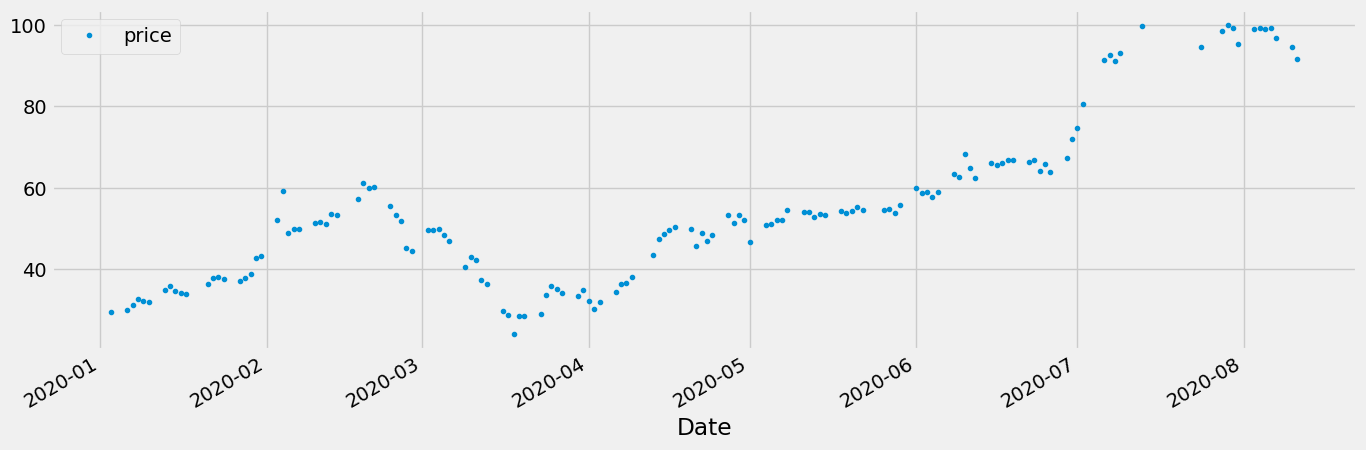

In [141]:
df[['price']].query('price < 100').plot(figsize=(15,5), style='.')

In [142]:
df2 = df[['price']].query('price > 100').copy()

### Train/Test Split

C:\Users\Eddie\AppData\Roaming\Python\Python311\site-packages\matplotlib\axis.py:1769: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ret = self.converter.convert(x, self.units, self)
C:\Users\Eddie\AppData\Roaming\Python\Python311\site-packages\matplotlib\axis.py:1769: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ret = self.converter.convert(x, self.units, self)


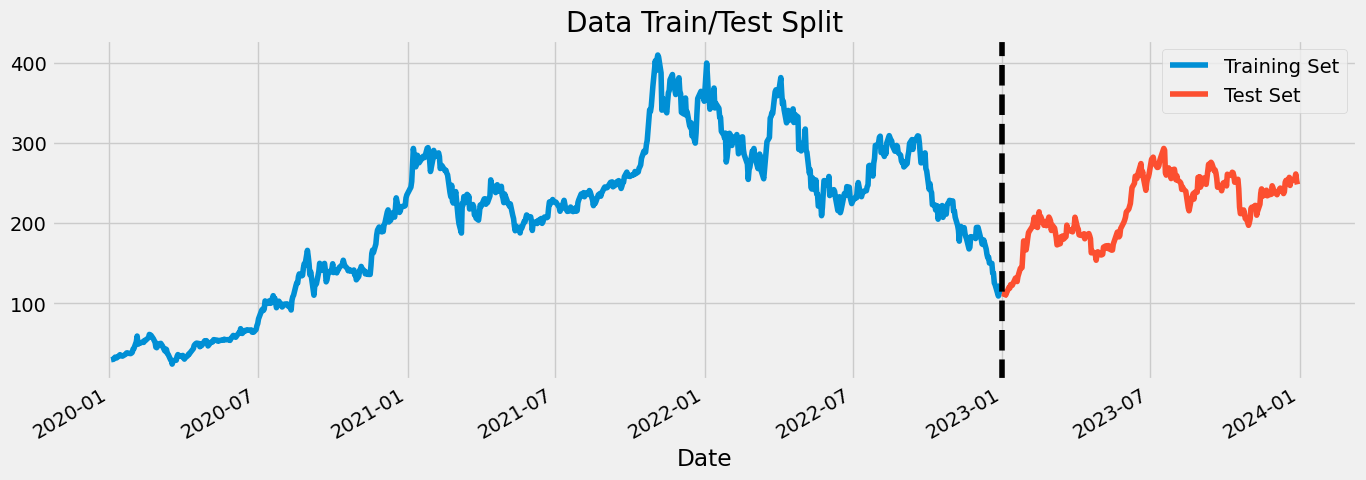

In [143]:
train = df.loc[df.index < '31-12-2022']
test = df.loc[df.index >= '31-12-2022']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('31-12-2022', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

## Build Model

> __Goal:__
- Outlier analysis
- Forecasting horizon explained
- Time series cross validation
- Lag Features
- Predicting the Future

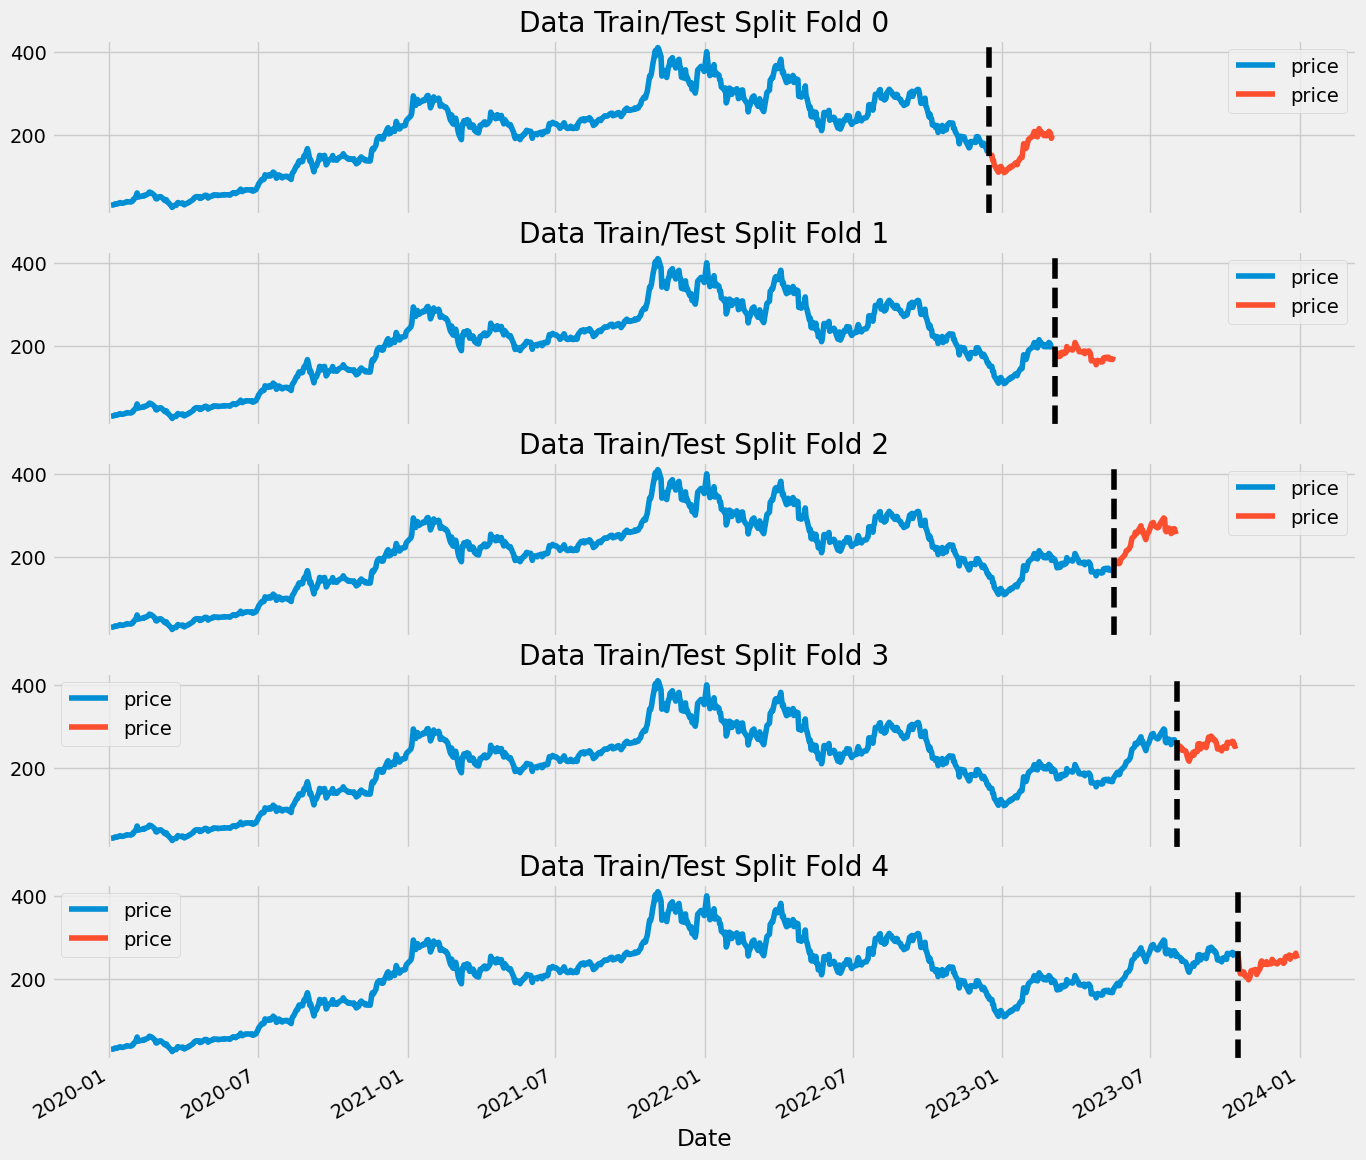

In [144]:
tss = TimeSeriesSplit(n_splits=5, test_size=52, gap=1)

fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train.plot(ax=axs[fold], 
               label='Training Set', 
               title=f'Data Train/Test Split Fold {fold}')
    test.plot(ax=axs[fold], 
              label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
    
plt.show()

### Lag Features

In [145]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofoweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

In [146]:
df = create_features(df)
df.head()

,price,hour,dayofoweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,
2020-01-03,29.534000,0,4,1,1,2020,3,3,1
2020-01-06,30.102667,0,0,1,1,2020,6,6,2
2020-01-07,31.270666,0,1,1,1,2020,7,7,2
2020-01-08,32.809334,0,2,1,1,2020,8,8,2
2020-01-09,32.089333,0,3,1,1,2020,9,9,2


In [147]:
def add_lags(df):
    target_map = df.price.to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [148]:
df = add_lags(df)
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1005 entries, 2020-01-03 to 2023-12-29
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       1005 non-null   float64
 1   hour        1005 non-null   int32  
 2   dayofoweek  1005 non-null   int32  
 3   quarter     1005 non-null   int32  
 4   month       1005 non-null   int32  
 5   year        1005 non-null   int32  
 6   dayofyear   1005 non-null   int32  
 7   dayofmonth  1005 non-null   int32  
 8   weekofyear  1005 non-null   UInt32 
 9   lag1        744 non-null    float64
 10  lag2        492 non-null    float64
 11  lag3        246 non-null    float64
dtypes: UInt32(1), float64(4), int32(7)
memory usage: 71.6 KB
None


,price,hour,dayofoweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Date,,,,,,,,,,,,
2023-12-22,252.539993,0,4,4,12,2023,356,22,51,123.150002,NaN,NaN
2023-12-26,256.609985,0,1,4,12,2023,360,26,52,109.099998,362.823334,221.996674
2023-12-27,261.440002,0,2,4,12,2023,361,27,52,112.709999,362.063324,231.593338
2023-12-28,253.179993,0,3,4,12,2023,362,28,52,121.820000,356.779999,235.223328
2023-12-29,248.479996,0,4,4,12,2023,363,29,52,123.180000,352.260010,NaN


### Train Using Cross Validation

In [152]:
tss = TimeSeriesSplit(n_splits=5, test_size=52, gap=1)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['hour','dayofoweek','quarter','month','year','dayofyear','dayofmonth', 
                'lag1','lag2','lag3']
    TARGET = 'price'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimator=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[22:23:08] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:23:08] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-rmse:226.09932	validation_1-rmse:162.17234
[99]	validation_0-rmse:88.23123	validation_1-rmse:33.57299
[22:23:09] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:23:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-rmse:222.47752	validation_1-rmse:176.36375
[99]	validation_0-rmse:87.34576	validation_1-rmse:63.23983
[22:23:09] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:li

In [153]:
print(f'Score across folds: {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Score across folds: 84.5764
Fold scores: [33.572994828351355, 63.239832883279256, 125.31520012686063, 98.6758292272015, 102.07837086300326]


### Predicting the Future
- Retraining on all data.
- To Predict the future we need an empty dataframe for future date ranges.
- Run those dates through our feature creation code + lag creation.

In [154]:
# Retrain on all data
df = create_features(df)

FEATURES = ['hour','dayofoweek','quarter','month','year','dayofyear','dayofmonth', 
                'lag1','lag2','lag3']
TARGET = 'price'
    
X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimator=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)
    

[22:23:46] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[22:23:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "n_estimator" } are not used.

[0]	validation_0-rmse:223.49104
[99]	validation_0-rmse:88.37938


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimator=1000, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [155]:
df4.index.max()

Timestamp('2023-12-29 00:00:00')

In [159]:
# Create future datafram
future = pd.date_range('2023-12-29 00:00:00', '2024-12-29 00:00:00')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])

In [160]:
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [162]:
future_w_features = df_and_future.query('isFuture').copy()

In [166]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

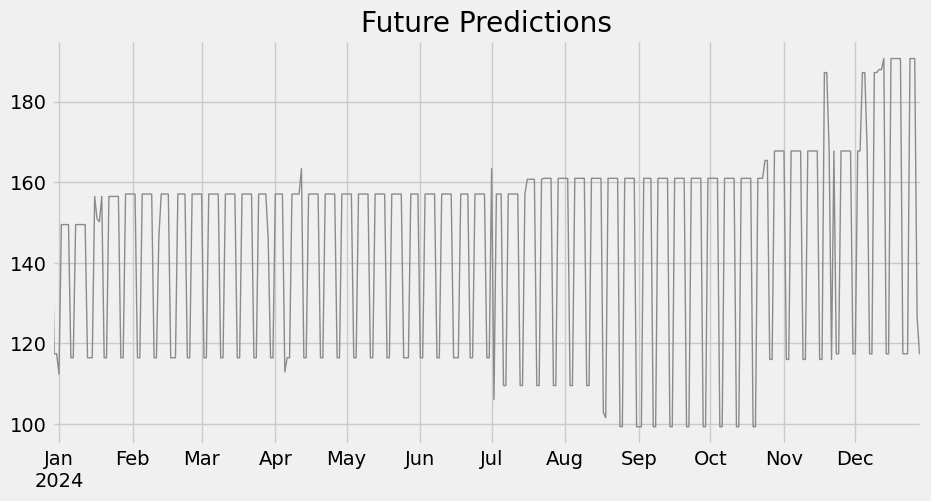

In [167]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

### Saving Model for later

In [169]:
# Save model
reg.save_model('model.json')

In [172]:
!ls -lh

'ls' is not recognized as an internal or external command,
operable program or batch file.


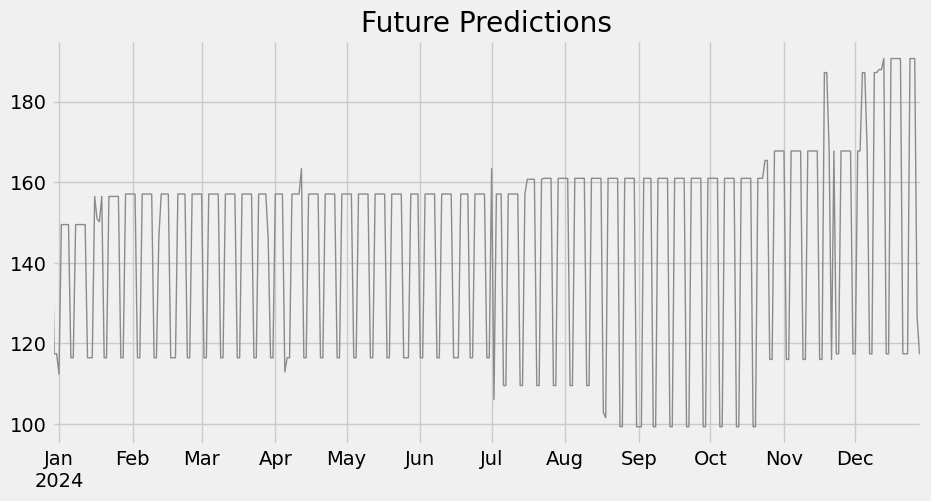

In [174]:
reg_new = xgb.XGBRFRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                              color=color_pal[4],
                              ms=1, lw=1,
                              title='Future Predictions')
plt.show()

## Communicate Results

In [ ]:
!pip install -q mlflow databricks-sdk

In [ ]:
import mlflow

# Host Name: https://community.cloud.databricks.com/
# Email: eddychetz@gmail.com
# Password: *********
mlflow.login()

In [ ]:
mlflow.set_tracking_uri("databricks")

In [ ]:
mlflow.set_experiment("/check-databricks-connection")

with mlflow.start_run():
    mlflow.log_metric("foo", 1)
    mlflow.log_metric("bar", 2)